In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from scipy import stats

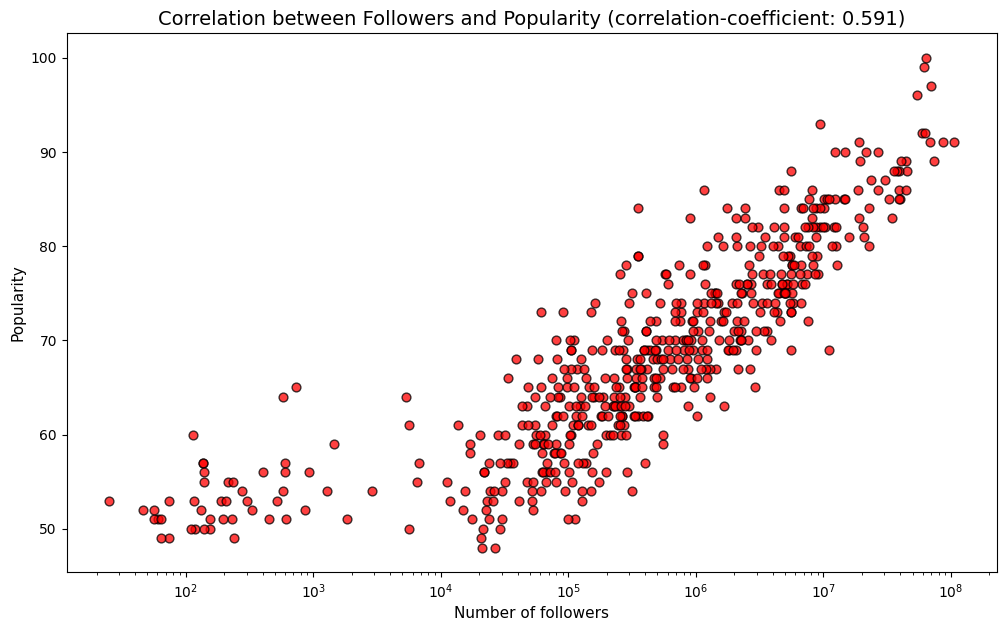

In [2]:
df = pd.read_csv("track_spotify_data.csv")
unique_artists = df['artist_name'].unique().tolist()

artists_followers_popularity = {}
for artist in unique_artists:
    rows_specific_artist = df.loc[df['artist_name'] == artist]
    
    unique_followers = rows_specific_artist['artist_followers'].unique().tolist()
    all_same_followers = all(followers == unique_followers[0] for followers in unique_followers)
    if not all_same_followers:
        print(f"Contradicting follower counts with artist {artist}")
    
    unique_popularity = rows_specific_artist['artist_popularity'].unique().tolist()
    all_same_popularity = all(followers == unique_followers[0] for followers in unique_followers)
    if not all_same_popularity:
        print(f"Contradicting popularity counts with artist {artist}")
        
    followers_popularity_tuple = (unique_followers[0], unique_popularity[0])
    artists_followers_popularity[artist] = followers_popularity_tuple

x = []
y = []

for artist in artists_followers_popularity:
    x.append(artists_followers_popularity[artist][0])
    y.append(artists_followers_popularity[artist][1])

sum_xy = 0
sum_x = 0
sum_y = 0
sum_xsquared = 0
sum_ysquared = 0
counter = 0
for value_x, value_y in zip(x, y):
    counter += 1
    sum_x += value_x
    sum_y += value_y
    sum_xsquared += value_x ** 2
    sum_ysquared += value_y ** 2
    sum_xy += value_x * value_y
        
r = (counter*sum_xy-sum_x*sum_y)/(((counter*sum_xsquared-sum_x**2)*(counter*sum_ysquared-sum_y**2))**0.5)
r = round(r, 3)

figure, axis = plt.subplots(figsize=(12, 7))
plt.subplot()
plt.scatter(x, y, s=40, c='red', edgecolor='black', linewidth=1, alpha=0.75)
plt.title(f"Correlation between Followers and Popularity (correlation-coefficient: {r})", fontsize = 14)
axis.set_xlabel("Number of followers", fontsize = 11)
axis.set_ylabel("Popularity", fontsize = 11)
plt.xscale('log')
plt.show()

R-squared: 0.0579
MAE: 4.5861


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


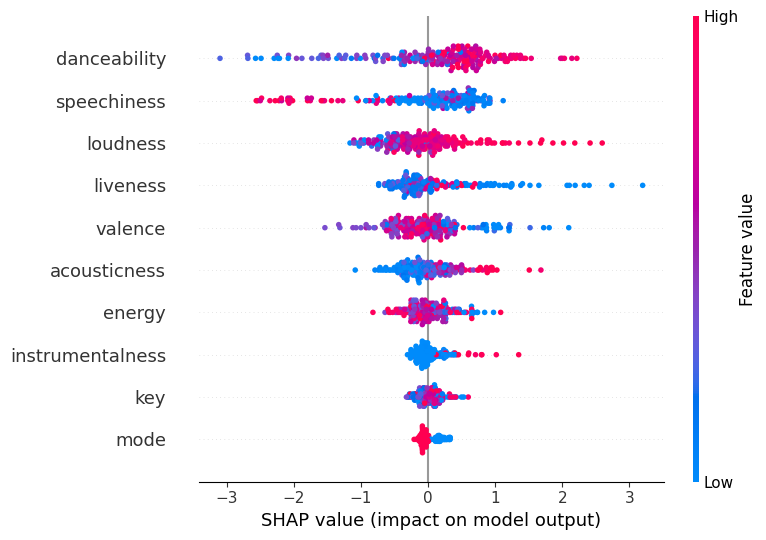

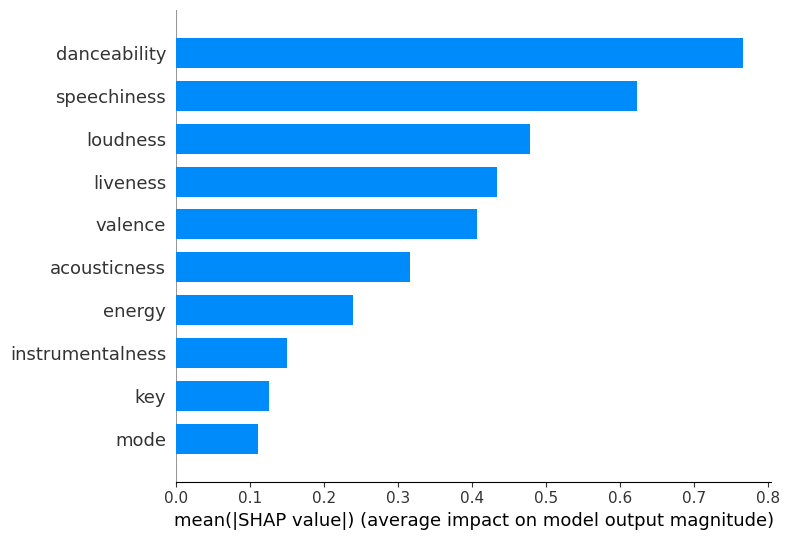

In [3]:
features = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
            "liveness", "valence", "track_popularity"]

df_features = pd.read_csv('feature_spotify_data.csv')

df_combined = df.merge(df_features, left_on="track_id", right_on="id", how="inner")
all_columns = list(df_combined)
unnecessary_columns = [i for i in all_columns if i not in features]
df_clean = df_combined.drop(unnecessary_columns, axis=1)

x2 = df_clean.drop('track_popularity', axis=1)
y2 = df_clean['track_popularity']

X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Accuracy
r2 = round(r2_score(y_test, y_pred), 4)
print('R-squared:', r2)
mae = round(mean_absolute_error(y_test, y_pred), 4)
print('MAE:', mae)

explainer = shap.Explainer(rf_model)
#shap_values = explainer(X_test)

shap_values = explainer.shap_values(X_test)
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

**Acousticness**: A measure from 0.0 to 1.0 that detects acoustic sounds in a track.

**Liveness**: A measure from 0.0 to 1.0 that detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

**Speechiness**: A measure from 0.0 to 1.0 that detects the presence of spoken words in a track. The more speech sounds are heard in the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the value will be.

**Instrumentalness:** A measure from 0.0 to 1 that reflects the extent to which a track does not contain vocalizations. The closer the instrumentalness value is to 1.0, the greater the likelihood that the track does not contain vocal content.

**Energy**: A measure from 0.0 to 1.0 that reflects the intensity of a track. Energetic tracks are usually fast, loud, and noisy.

**Loudness**: A measure from -60 and 0 that represents the overall loudness of a track. This value is measured in decibels (dB). Loudness values are averaged across the entire track.

**Danceability**: A measure from 0.0 to 1 that indicates how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, and beat strength. A value closer to 0.0 indicates that a track is less danceable, and value closer to 1.0 is indicates that a track is more danceable.

**Valence**: A measure from 0.0 to 1.0 that reflects the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

**Key**: A measure from 0 to 11 that indicates the key of a track.

**Mode**: A measure that indicates the key in the music of the track (1 is major, and 0 is for minor)

Source: https://rpubs.com/kdrdatascience/862303#:~:text=Speechiness%3A%20A%20measure%20from%200.0,1.0%20the%20value%20will%20be

In [4]:
df_sorted = df_combined.sort_values('track_popularity', ascending=False)
top_100 = df_sorted.head(100)

medians_per_feature = {}
medians_per_feature_100 = {}

for feature in features:
    medians_per_feature_100[feature] = top_100[feature].median()
    medians_per_feature[feature] = df_clean[feature].median()

median_tempo = df_combined["tempo"].median()
median_duration = df_combined["duration_ms"].median()
mode_key = df_combined["key"].mode()[0]
mode_mode = df_combined["mode"].mode()[0]
print(f"All data: Median tempo: {int(median_tempo)}, Median duration min: {round(median_duration/60000,2)}, Mode key: {mode_key}, Mode mode: {mode_mode}")

median_tempo_100 = top_100["tempo"].median()
median_duration_100 = top_100["duration_ms"].median()
mode_key_100 = top_100["key"].mode()[0]
mode_mode_100 = top_100["mode"].mode()[0]
print(f"Top 100: Median tempo: {int(median_tempo_100)}, Median duration min: {round(median_duration_100/60000,2)}, Mode key: {mode_key_100}, Mode mode: {mode_mode_100}")
print("-----------------------")
medians = pd.DataFrame(medians_per_feature, index = [1])
medians_100 = pd.DataFrame(medians_per_feature_100, index = [1])
print("     All data:")
display(medians)
print("     Top 100:")
display(medians_100)

#display(top_100)

All data: Median tempo: 123, Median duration min: 3.08, Mode key: 1, Mode mode: 1
Top 100: Median tempo: 125, Median duration min: 3.22, Mode key: 1, Mode mode: 1
-----------------------
     All data:


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,track_popularity
1,0.649,0.6345,5.0,-6.444,1.0,0.05885,0.1685,0.0,0.123,0.4785,71.0


     Top 100:


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,track_popularity
1,0.6745,0.6925,5.0,-5.8035,1.0,0.0533,0.152,0.000002,0.12,0.4625,83.0


In [5]:
correlations = df_clean.corr().sort_values('track_popularity', ascending=False, key=abs)
excess_columns = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
            "liveness", "valence"]
correlations = correlations.drop(excess_columns, axis=1)
#display(df_clean)
popularity_list = df_clean[df_clean.columns[0]].values.tolist()
ps = []
for column in df_clean:
    col_values = df_clean[column].values.tolist()
    res = stats.pearsonr(popularity_list, col_values)
    print(f"{column} = {res}")

display(correlations)

track_popularity = PearsonRResult(statistic=0.9999999999999986, pvalue=0.0)
danceability = PearsonRResult(statistic=0.11034195154687751, pvalue=0.00048552453638849247)
energy = PearsonRResult(statistic=0.038128546315649915, pvalue=0.22926949502993677)
key = PearsonRResult(statistic=0.030015659728675686, pvalue=0.34399461593611136)
loudness = PearsonRResult(statistic=0.1273738635369148, pvalue=5.548485440217048e-05)
mode = PearsonRResult(statistic=-0.0649949787576727, pvalue=0.04028644542923846)
speechiness = PearsonRResult(statistic=-0.10586574484392229, pvalue=0.0008190407338410405)
acousticness = PearsonRResult(statistic=0.017162327705696118, pvalue=0.588511983146875)
instrumentalness = PearsonRResult(statistic=-0.03161506920548319, pvalue=0.31888539340665456)
liveness = PearsonRResult(statistic=-0.03694205487658829, pvalue=0.24409787481255837)
valence = PearsonRResult(statistic=0.03172766399575734, pvalue=0.31716407453550344)


,track_popularity
track_popularity,1.000000
loudness,0.127374
danceability,0.110342
speechiness,-0.105866
mode,-0.064995
energy,0.038129
liveness,-0.036942
valence,0.031728
instrumentalness,-0.031615
key,0.030016
